In [6]:
import torch
from torch import nn

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
N_CLASSES = 4
N_FEATURES = 2
SEED = 42

X, y = make_blobs(n_samples=1000,
                  n_features=N_FEATURES,
                  centers=N_CLASSES,
                  cluster_std=1.5,
                  random_state=SEED)

In [5]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

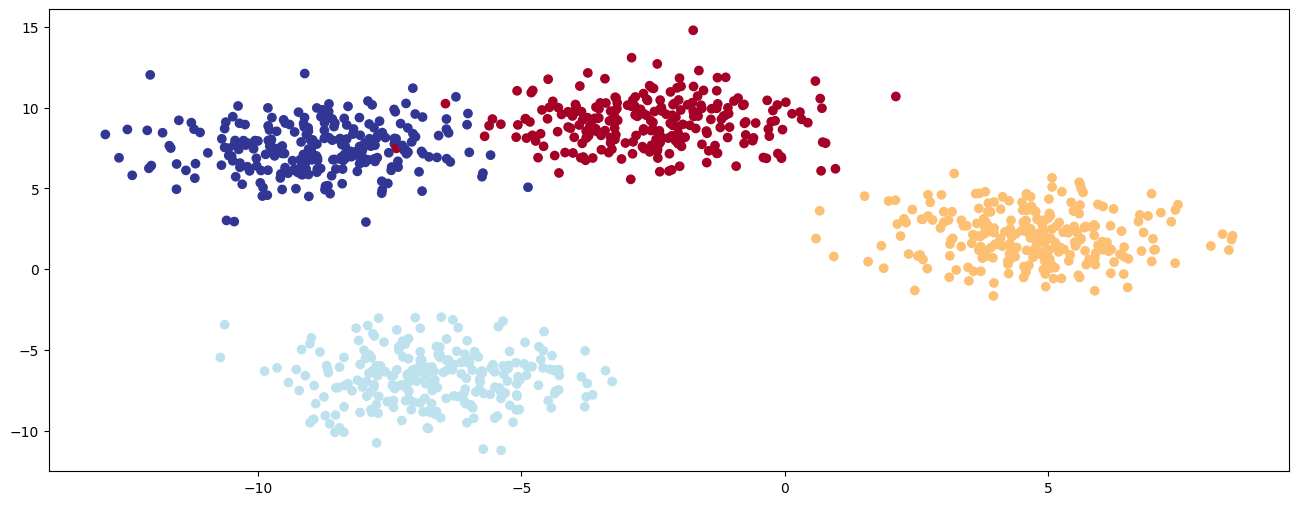

In [7]:
plt.figure(figsize=(16, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [11]:
class BlobModel(nn.Module):

  def __init__(self, input_size, output_size):

    super().__init__()
    self.seq = nn.Sequential(
        nn.Linear(in_features=input_size, out_features=8),
        nn.Linear(in_features=8, out_features=8),
        nn.Linear(in_features=8, out_features=output_size)
    )

  def forward(self, x):
    return self.seq(x)

In [12]:
model = BlobModel(input_size=N_FEATURES,
                  output_size=N_CLASSES).to(device)
model

BlobModel(
  (seq): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=1e-2)

In [18]:
model(X_test)[:5].argmax(dim=1).shape

torch.Size([5])

In [23]:
def accuracy_fn(y_true, y_preds):
  return ((y_true == y_preds).sum().item() / len(y_preds)) * 100

In [21]:
torch.manual_seed(SEED)

epochs = 100

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
  model.train()

  y_logits = model(X_train)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_preds=y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_preds=test_preds)

  if epoch % 10 == 0:
    print(f'Epoch: {epoch + 1} | Train Loss: {loss.item():.4f} | Train Accuracy: {acc:.4f} | Test Loss: {test_loss.item():.4f} | Test Accuracy: {test_acc}')

Epoch: 1 | Train Loss: 2.3825 | Train Accuracy: 25.1250 | Test Loss: 2.0734 | Test Accuracy: 24.5
Epoch: 11 | Train Loss: 0.6798 | Train Accuracy: 76.3750 | Test Loss: 0.6356 | Test Accuracy: 79.0
Epoch: 21 | Train Loss: 0.4528 | Train Accuracy: 97.3750 | Test Loss: 0.4312 | Test Accuracy: 99.0
Epoch: 31 | Train Loss: 0.3522 | Train Accuracy: 98.7500 | Test Loss: 0.3388 | Test Accuracy: 99.0
Epoch: 41 | Train Loss: 0.2900 | Train Accuracy: 99.1250 | Test Loss: 0.2808 | Test Accuracy: 99.0
Epoch: 51 | Train Loss: 0.2469 | Train Accuracy: 99.1250 | Test Loss: 0.2399 | Test Accuracy: 99.0
Epoch: 61 | Train Loss: 0.2151 | Train Accuracy: 99.0000 | Test Loss: 0.2094 | Test Accuracy: 99.0
Epoch: 71 | Train Loss: 0.1906 | Train Accuracy: 99.0000 | Test Loss: 0.1856 | Test Accuracy: 99.0
Epoch: 81 | Train Loss: 0.1713 | Train Accuracy: 99.0000 | Test Loss: 0.1666 | Test Accuracy: 99.0
Epoch: 91 | Train Loss: 0.1556 | Train Accuracy: 99.0000 | Test Loss: 0.1511 | Test Accuracy: 99.5


In [24]:
model.eval()
with torch.inference_mode():
  y_logits = model(X_test)
  y_preds = torch.argmax(y_logits, dim=1)

accuracy_fn(y_true=y_test, y_preds=y_preds)

99.5